In [1]:
#imports
import uproot as ur
import awkward as ak
import numpy as np

data_path = '/fast_scratch/atlas_images/v01-45/'

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2" #specify GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/Users/swiatlow/Code/ML4P/LCStudies')
sys.path.append('/home/mswiatlowski/start_tf/LCStudies')
import graph_util as gu
import plot_util as pu

path_pipm = data_path + 'pipm_medium.root'
path_pi0  = data_path + 'pi0_medium.root'


In [3]:
#load up data
pipm_med = np.load('/fast_scratch/atlas_images/v01-45/pipm_medium.npz')
pi0_med = np.load('/fast_scratch/atlas_images/v01-45/pi0_medium.npz')

In [4]:
#extract data
X_pipm = pipm_med['X']
X_pi0 = pi0_med['X']

Y_label_pipm = pipm_med['Y_label']
Y_label_pi0 = pi0_med['Y_label']

clus_eta_pipm = pipm_med['clus_eta']
clus_eta_pi0 = pi0_med['clus_eta']

In [5]:
#select size of datasets
X_all = np.concatenate((X_pipm[:390000], X_pi0[:390000]))
Y_all = tf.keras.utils.to_categorical(np.concatenate((Y_label_pipm[:390000],Y_label_pi0[:390000])))
eta = np.concatenate((clus_eta_pipm[:390000], clus_eta_pi0[:390000]))
X_glob = np.concatenate((clus_eta_pipm[:390000], clus_eta_pi0[:390000]))

In [6]:
model = tf.keras.models.load_model('./w6_pfn4')

In [7]:
#rerun in order to examine 'best' model (this was produced in a different notebook)
(X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_tr, X_glob_val, X_glob_te, eta_train, eta_val, eta_test) = data_split(X_all, Y_all, X_glob, eta, val=100000, test=100000)

In [9]:
#concatenate the Xs:
X_tr = [X_train, X_glob_tr]
X_vali = [X_val, X_glob_val]
X_te = [X_test, X_glob_te]

#define the different eta regions
selec_l02 = abs(eta_test) < 0.2
selec_b0207 = (abs(eta_test) >= .2) & (abs(eta_test) < .7)
selec_b0713 = (abs(eta_test) >= .7) & (abs(eta_test) < 1.3)
selec_b1317 = (abs(eta_test) >= 1.3) & (abs(eta_test) < 1.8)
selec_b1825 = (abs(eta_test) >= 1.8) & (abs(eta_test) < 2.5)
selec_b2531 = (abs(eta_test) >= 2.5) & (abs(eta_test) < 4.)
selec_all = abs(eta_test) <= 4. 

selections = [selec_l02, selec_b0207, selec_b0713, selec_b1317, selec_b1825, selec_b2531, selec_all]

#make metrics
X_1, X_2 = X_te
fps = []
tps = []
threshss = []
aucs = []
for selection in selections:
    X_interm = [X_1[selection], X_2[selection]]
    preds = model.predict(X_interm, batch_size=1000) 
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[selection][:,1], preds[:,1])

    fps.append(pfn_fp)
    tps.append(pfn_tp)
    threshss.append(threshs)

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[selection][:,1], preds[:,1])
    aucs.append(auc)
    print('PFN AUC:', auc)


PFN AUC: 0.9817653182629388
PFN AUC: 0.9822234940215406
PFN AUC: 0.9780379747752447
PFN AUC: 0.9451954650037423
PFN AUC: 0.9531418666573206
PFN AUC: 0.9861679302815186
PFN AUC: 0.9691683194309867


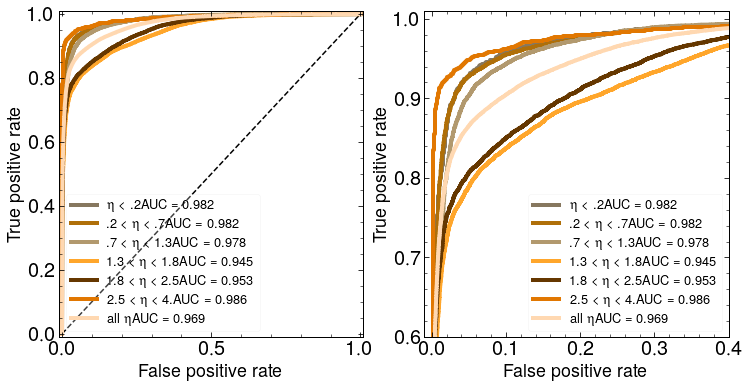

In [11]:
labs = ['$\eta$ < .2', '.2 < $\eta$ < .7', '.7 < $\eta$ < 1.3', '1.3 < $\eta$ < 1.8','1.8 < $\eta$ < 2.5', '2.5 < $\eta$ < 4.', 'all $\eta$']
 
fig2, (ax3, ax4) = plt.subplots(1,2, figsize=[12,6])
    
ax3.set_xlim(-.01,1.01)
ax3.set_ylim(-.01,1.01)
ax3.plot([0, 1], [0, 1], 'k--')
ax3.plot(fps[0], tps[0], c='xkcd:brownish grey', linewidth=4, label=labs[0] + 'AUC = %.3f '%aucs[0])
ax3.plot(fps[1], tps[1], c='xkcd:caramel', linewidth=4, label=labs[1] + 'AUC = %.3f '%aucs[1])
ax3.plot(fps[2], tps[2], c='xkcd:dust', linewidth=4, label=labs[2] + 'AUC = %.3f '%aucs[2])
ax3.plot(fps[3], tps[3], c='xkcd:mango', linewidth=4, label=labs[3] + 'AUC = %.3f '%aucs[3])
ax3.plot(fps[4], tps[4], c='xkcd:brown', linewidth=4, label=labs[4] + 'AUC = %.3f '%aucs[4])
ax3.plot(fps[5], tps[5], c='xkcd:pumpkin', linewidth=4, label=labs[5] + 'AUC = %.3f '%aucs[5])
ax3.plot(fps[6], tps[6], c='xkcd:light peach', linewidth=4, label=labs[6] + 'AUC = %.3f '%aucs[6])
ax3.set_ylabel('True positive rate')
ax3.set_xlabel('False positive rate')
ax3.legend() 

ax4.set_xlim(-.01,.4)
ax4.set_ylim(.6,1.01)
ax4.plot([0, 1], [0, 1], 'k--')
ax4.plot(fps[0], tps[0], c='xkcd:brownish grey', linewidth=4, label=labs[0] + 'AUC = %.3f '%aucs[0])
ax4.plot(fps[1], tps[1], c='xkcd:caramel', linewidth=4, label=labs[1] + 'AUC = %.3f '%aucs[1])
ax4.plot(fps[2], tps[2], c='xkcd:dust', linewidth=4, label=labs[2] + 'AUC = %.3f '%aucs[2])
ax4.plot(fps[3], tps[3], c='xkcd:mango', linewidth=4, label=labs[3] + 'AUC = %.3f '%aucs[3])
ax4.plot(fps[4], tps[4], c='xkcd:brown', linewidth=4, label=labs[4] + 'AUC = %.3f '%aucs[4])
ax4.plot(fps[5], tps[5], c='xkcd:pumpkin', linewidth=4, label=labs[5] + 'AUC = %.3f '%aucs[5])
ax4.plot(fps[6], tps[6], c='xkcd:light peach', linewidth=4, label=labs[6] + 'AUC = %.3f '%aucs[6])
ax4.set_ylabel('True positive rate')
ax4.set_xlabel('False positive rate')
ax4.legend() 